![](img/330-banner.png)

# Lecture 2: Terminology, Baselines, Decision Trees

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports, Announcements, LOs

### Imports

In [1]:
import glob
import os
import re
import sys
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append("code/.")
import graphviz
import IPython
import mglearn
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from utils import *

plt.rcParams["font.size"] = 16
pd.set_option("display.max_colwidth", 200)


### Announcements 

- Things due this week 
    - Homework 1 (hw1): Sept 13, 11:59pm 
- Homework 2 (hw2) will been released later today (Due: Sept 19, 11:59pm)
    - You need to install `otter-grader` for this homework. 
- You can find the tentative due dates for all deliverables [here](https://ubc-cs.github.io/cpsc330/README.html#deliverable-due-dates-tentative). 
- Please monitor Piazza (especially pinned posts and instructor posts) for announcements. 
- Sorry for the setup difficulties. That said, you are likely to go through this in future and figuring out these things on your own is a valuable skill.

<br><br>

### Learning outcomes 
From this lecture, you will be able to 

- identify whether a given problem could be solved using supervised machine learning or not; 
- differentiate between supervised and unsupervised machine learning;
- explain machine learning terminology such as features, targets, predictions, training, and error;
- differentiate between classification and regression problems;
- use `DummyClassifier` and `DummyRegressor` as baselines for machine learning problems;
- explain the `fit` and `predict` paradigm and use `score` method of ML models; 
- broadly describe how decision tree prediction works;
- use `DecisionTreeClassifier` and `DecisionTreeRegressor` to build decision trees using `scikit-learn`; 
- visualize decision trees; 
- explain the difference between parameters and hyperparameters; 
- explain the concept of decision boundaries;
- explain the relation between model complexity and decision boundaries.

<br><br>

<br><br><br><br>

## Terminology [[video](https://youtu.be/YNT8n4cXu4A)]

You will see a lot of variable terminology in machine learning and statistics. Let's familiarize ourselves with some of the basic terminology used in ML. 

```{seealso}
Check out [the accompanying video](https://youtu.be/YNT8n4cXu4A) on this material. 
```

### Big picture and datasets

In this lecture, we'll talk about our first machine learning model: Decision trees. We will also familiarize ourselves with some common terminology in supervised machine learning.

### Toy datasets 
Later in the course we will use larger datasets from Kaggle, for instance. But for our first couple of lectures, we will be working with the following three toy datasets:  

- [Quiz2 grade prediction classification dataset](data/quiz2-grade-toy-classification.csv)
- [Quiz2 grade prediction regression dataset](data/quiz2-grade-toy-regression.csv)
- [Canada USA cities dataset](canada_usa_cities.csv)

```{note} 
If it's not necessary for you to understand the code, I will put it in one of the files under the `code` directory to avoid clutter in this notebook. For example, most of the plotting code is going to be in `code/plotting_functions.py`. 
```

I'll be using the following grade prediction toy dataset to demonstrate the terminology. Imagine that you are taking a course with four home work assignments and two quizzes. You and your friends are quite nervous about your quiz2 grades and you want to know how will you do based on your previous performance and some other attributes. So you decide to collect some data from your friends from last year and train a supervised machine learning model for quiz2 grade prediction. 

In [2]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
print(classification_df.shape)
classification_df.head()

(21, 8)


,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


### Recap: Supervised machine learning

![](img/sup-learning.png)
<!-- <img src="img/sup-learning.png" height="800" width="800">  -->

### Tabular data
In supervised machine learning, the input data is typically organized in a **tabular** format, where rows are **examples** and columns are **features**. One of the columns is typically the **target**. 

![](img/sup-ml-terminology.png)

<!-- <img src="img/sup-ml-terminology.png" height="1000" width="1000">  -->

**Features** 
: Features are relevant characteristics of the problem, usually suggested by experts. Features are typically denoted by $X$ and the number of features is usually denoted by $d$.  

**Target**
: Target is the feature we want to predict (typically denoted by $y$). 

**Example** 
: A row of feature values. When people refer to an example, it may or may not include the target corresponding to the feature values, depending upon the context. The number of examples is usually denoted by $n$. 

**Training**
: The process of learning the mapping between the features ($X$) and the target ($y$). 

#### Example: Tabular data for grade prediction

The tabular data usually contains both: the features (`X`) and the target (`y`). 

In [3]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


So the first step in training a supervised machine learning model is separating `X` and `y`. 

In [4]:
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]
X.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,92,93,84,91,92
1,1,0,94,90,80,83,91
2,0,0,78,85,83,80,80
3,0,1,91,94,92,91,89
4,0,1,77,83,90,92,85


In [5]:
y.head()

0        A+
1    not A+
2    not A+
3        A+
4        A+
Name: quiz2, dtype: object

#### Example: Tabular data for the housing price prediction

Here is an example of tabular data for housing price prediction. You can download the data from [here](https://www.kaggle.com/harlfoxem/housesalesprediction). 

In [6]:
housing_df = pd.read_csv("data/kc_house_data.csv")
housing_df.drop(["id", "date"], axis=1, inplace=True)
HTML(housing_df.head().to_html(index=False))

price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
X = housing_df.drop(columns=["price"])
y = housing_df["price"]
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [8]:
y.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [9]:
X.shape

(21613, 18)

```{admonition} Attention
:class: important
To a machine, column names (features) have no meaning. Only feature values and how they vary across examples mean something. 
```

<br><br>

#### Alternative terminology for examples, features, targets, and training

- **examples** = rows = samples = records = instances 
- **features** = inputs = predictors = explanatory variables = regressors = independent variables = covariates
- **targets** = outputs = outcomes = response variable = dependent variable = labels (if categorical).
- **training** = learning = fitting

```{seealso} 
Check out [the MDS terminology document](https://ubc-mds.github.io/resources_pages/terminology/). 
```

<br><br>

### Supervised learning vs. Unsupervised learning

In **supervised learning**, training data comprises a set of features ($X$) and their corresponding targets ($y$). We wish to find a **model function $f$** that relates $X$ to $y$. Then use that model function **to predict the targets** of new examples. 


![](img/sup-learning.png)

<!-- <img src="img/sup-learning.png" height="900" width="900"> -->


In **unsupervised learning** training data consists of observations ($X$) **without any corresponding targets**. Unsupervised learning could be used to **group similar things together** in $X$ or to provide **concise summary** of the data. We'll learn more about this topic in later videos.

![](img/unsup-learning.png)

<!-- <img src="img/unsup-learning.png" alt="" height="900" width="900"> -->

Supervised machine learning is about function approximation, i.e., finding the mapping function between `X` and `y` whereas unsupervised machine learning is about concisely describing the data.   


<br><br>

### Classification vs. Regression 
In supervised machine learning, there are two main kinds of learning problems based on what they are trying to predict.
- **Classification problem**: predicting among two or more discrete classes
    - Example1: Predict whether a patient has a liver disease or not
    - Example2: Predict whether a student would get an A+ or not in quiz2.  
- **Regression problem**: predicting a continuous value
    - Example1: Predict housing prices 
    - Example2: Predict a student's score in quiz2.

![](img/classification-vs-regression.png)
<!-- <img src="img/classification-vs-regression.png" height="1500" width="1500">  -->

In [10]:
# quiz2 classification toy data
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head(4)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+


In [11]:
# quiz2 regression toy data
regression_df = pd.read_csv("data/quiz2-grade-toy-regression.csv")
regression_df.head(4)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,90
1,1,0,94,90,80,83,91,84
2,0,0,78,85,83,80,80,82
3,0,1,91,94,92,91,89,92


## ❓❓ Questions for you

### Exercise 2.1 Select all of the following statements which are examples of supervised machine learning 

1. How many examples and features are there in the housing price data above? You can use `df.shape` to get number of rows and columns in a dataframe. 
2. For each of the following examples what would be the relevant features and what would be the target?
    1. Sentiment analysis
    2. Fraud detection 
    3. Face recognition 

<br><br>

### iClicker Exercise 2.2 


**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are examples of supervised machine learning**

- (A) Finding groups of similar properties in a real estate data set.
- (B) Predicting whether someone will have a heart attack or not on the basis of demographic, diet, and clinical measurement. 
- (C) Grouping articles on different topics from different news sources (something like the Google News app). 
- (D) Detecting credit card fraud based on examples of fraudulent and non-fraudulent transactions.
- (E) Given some measure of employee performance, identify the key factors which are likely to influence their performance.

<br><br>

### iClicker Exercise 2.3 


**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are examples of regression problems**

- (A) Predicting the price of a house based on features such as number of bedrooms and the year built.
- (B) Predicting if a house will sell or not based on features like the price of the house, number of rooms, etc.
- (C) Predicting percentage grade in CPSC 330 based on past grades.
- (D) Predicting whether you should bicycle tomorrow or not based on the weather forecast.
- (E) Predicting appropriate thermostat temperature based on the wind speed and the number of people in a room.   

<br><br><br><br>

## Baselines [[video](https://youtu.be/6eT5cLL-2Vc)]

```{seealso}
Check out [the accompanying video](https://youtu.be/6eT5cLL-2Vc) on this material. 
```

### Supervised learning (Reminder)

- Training data $\rightarrow$ Machine learning algorithm $\rightarrow$ ML model 
- Unseen test data + ML model $\rightarrow$ predictions
![](img/sup-learning.png)
<!-- <img src="img/sup-learning.png" height="1000" width="1000">  -->


Let's build a very simple supervised machine learning model for quiz2 grade prediction problem. 

In [12]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
classification_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


In [13]:
classification_df['quiz2'].value_counts()

not A+    11
A+        10
Name: quiz2, dtype: int64

Seems like "not A+" occurs more frequently than "A+". What if we predict "not A+" all the time? 

### Baselines 

**Baseline**
: A simple machine learning algorithm based on simple rules of thumb. 

- For example, most frequent baseline always predicts the most frequent label in the training set. 
- Baselines provide a way to sanity check your machine learning model.    

### `DummyClassifier` 

- `sklearn`'s baseline model for classification  
- Let's train `DummyClassifier` on the grade prediction dataset. 

### Steps to train a classifier using `sklearn` 

1. Read the data
2. Create $X$ and $y$
3. Create a classifier object
4. `fit` the classifier
5. `predict` on new examples
6. `score` the model

#### Reading the data

In [14]:
classification_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,A+
1,1,0,94,90,80,83,91,not A+
2,0,0,78,85,83,80,80,not A+
3,0,1,91,94,92,91,89,A+
4,0,1,77,83,90,92,85,A+


#### Create $X$ and $y$

- $X$ &rarr; Feature vectors
- $y$ &rarr; Target

In [15]:
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]

#### Create a classifier object

- `import` the appropriate classifier 
- Create an object of the classifier 

In [16]:
from sklearn.dummy import DummyClassifier # import the classifier

dummy_clf = DummyClassifier(strategy="most_frequent") # Create a classifier object

#### `fit` the classifier

- The "learning" is carried out when we call `fit` on the classifier object. 

In [17]:
dummy_clf.fit(X, y); # fit the classifier

#### `predict` the target of given examples

- We can predict the target of examples by calling `predict` on the classifier object. 

In [18]:
dummy_clf.predict(X) # predict using the trained classifier

array(['not A+', 'not A+', 'not A+', 'not A+', 'not A+', 'not A+',
       'not A+', 'not A+', 'not A+', 'not A+', 'not A+', 'not A+',
       'not A+', 'not A+', 'not A+', 'not A+', 'not A+', 'not A+',
       'not A+', 'not A+', 'not A+'], dtype='<U6')

#### `score` your model

- How do you know how well your model is doing?
- For classification problems, by default, `score` gives the **accuracy** of the model, i.e., proportion of correctly predicted targets.  

    $accuracy = \frac{\text{correct predictions}}{\text{total examples}}$   

In [19]:
print("The accuracy of the model on the training data: %0.3f" % (dummy_clf.score(X, y)))

The accuracy of the model on the training data: 0.524


- Sometimes you will also see people reporting **error**, which is usually $1 - accuracy$ 
- `score` 
    - calls `predict` on `X` 
    - compares predictions with `y` (true targets)
    - returns the accuracy in case of classification.  

In [20]:
print(
    "The error of the model on the training data: %0.3f" % (1 - dummy_clf.score(X, y))
)

The error of the model on the training data: 0.476


#### `fit`, `predict` , and `score` summary

Here is the general pattern when we build ML models using `sklearn`. 

In [21]:
# Create `X` and `y` from the given data
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]

clf = DummyClassifier(strategy="most_frequent") # Create a class object
clf.fit(X, y) # Train/fit the model
print(clf.score(X, y)) # Assess the model

new_examples = [[0, 1, 92, 90, 95, 93, 92], [1, 1, 92, 93, 94, 92]]
clf.predict(new_examples) # Predict on some new data using the trained model

0.5238095238095238


array(['not A+', 'not A+'], dtype='<U6')

```{note} 
You'll be exploring dummy classifier in your lab!
```

### [`DummyRegressor`](https://scikit-learn.org/0.15/modules/generated/sklearn.dummy.DummyRegressor.html)

You can also do the same thing for regression problems using `DummyRegressor`, which predicts mean, median, or constant value of the training set for all examples. 

- Let's build a regression baseline model using `sklearn`. 

In [22]:
from sklearn.dummy import DummyRegressor

regression_df = pd.read_csv("data/quiz2-grade-toy-regression.csv") # Read data 
X = regression_df.drop(columns=["quiz2"]) # Create `X` and `y` from the given data
y = regression_df["quiz2"]
reg = DummyRegressor() # Create a class object
reg.fit(X, y) # Train/fit the model
reg.score(X, y) # Assess the model
new_examples = [[0, 1, 92, 90, 95, 93, 92], [1, 1, 92, 93, 94, 92]]
reg.predict(new_examples) # Predict on some new data using the trained model

array([86.28571429, 86.28571429])

- The `fit` and `predict` paradigms similar to classification. The `score` method in the context of regression returns somethings called [$R^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score). (More on this in later videos.)     
    - The maximum $R^2$ is 1 for perfect predictions. 
    - For `DummyRegressor` it returns the mean of the `y` values.   

In [23]:
reg.score(X, y)

0.0

<br><br>

## ❓❓ Questions for you

### Exercise 2.4

1. Order the steps below to build ML models using `sklearn`. 
    - `score` to evaluate the performance of a given model
    - `predict` on new examples 
    - Creating a model instance
    - Creating `X` and `y` 
    - `fit`

<br><br><br><br>

## Break (5 min)

![](img/eva-coffee.png)

- We will try to take a 5-minute break half way through every class.

<br><br><br><br>

## Decision trees [[video](https://youtu.be/Hcf19Ij35rA)]

```{seealso}
Check out [the accompanying video](https://youtu.be/Hcf19Ij35rA) on this material. 
```

### Writing a traditional program to predict quiz2 grade

- Can we do better than the baseline? 
- Forget about ML for a second. If you are asked to write a program to predict whether a student gets an A+ or not in quiz2, how would you go for it?  
- For simplicity, let's binarize the feature values. 

![](img/quiz2-grade-toy.png)

<!-- <img src="img/quiz2-grade-toy.png" height="700" width="700">  -->


- Is there a pattern that distinguishes yes's from no's and what does the pattern say about today? 
- How about a rule-based algorithm with a number of *if else* statements?  
    ```
    if class_attendance == 1 and quiz1 == 1:
        quiz2 == "A+"
    elif class_attendance == 1 and lab3 == 1 and lab4 == 1:
        quiz2 == "A+"
    ...
    ```

- How many possible rule combinations there could be with the given 7 binary features? 
    - Gets unwieldy pretty quickly 

### Decision tree algorithm 

- A machine learning algorithm to derive such rules from data in a principled way.  
- Have you ever played [20-questions game](https://en.wikipedia.org/wiki/Twenty_questions)? Decision trees are based on the same idea! 
- Let's `fit` a decision tree using `scikit-learn` and `predict` with it.
- Recall that `scikit-learn` uses the term `fit` for training or learning and uses `predict` for prediction. 

### Building decision trees with `sklearn`

Let's binarize our toy dataset for simplicity. 

In [24]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]

X_binary = X.copy()
columns = ["lab1", "lab2", "lab3", "lab4", "quiz1"]
for col in columns:
    X_binary[col] = X_binary[col].apply(lambda x: 1 if x >= 90 else 0)
X_binary.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,1,1,0,1,1
1,1,0,1,1,0,0,1
2,0,0,0,0,0,0,0
3,0,1,1,1,1,1,0
4,0,1,0,0,1,1,0


In [25]:
y.head()

0        A+
1    not A+
2    not A+
3        A+
4        A+
Name: quiz2, dtype: object

#### `DummyClassifier` on quiz2 grade prediction toy dataset 

In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_binary, y)
dummy_clf.score(X_binary, y)

0.5238095238095238

#### `DecisionTreeClassifier` on quiz2 grade prediction toy dataset 

In [27]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # Create a decision tree
model.fit(X_binary, y) # Fit a decision tree
model.score(X_binary, y) # Assess the model

0.9047619047619048

The decision tree classifier is giving much higher accuracy than the dummy classifier. That's good news! 

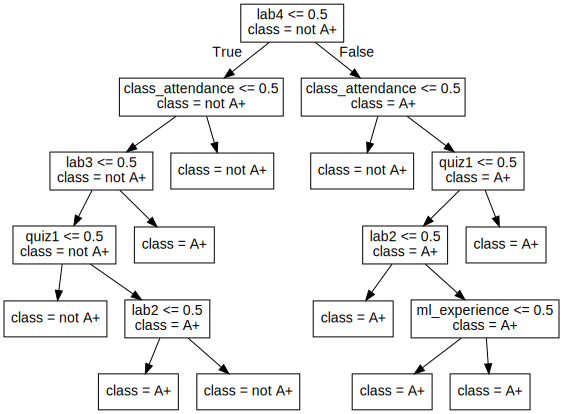

In [28]:
display_tree(X_binary.columns, model) # model visualization

### Some terminology related to trees 

Here is a commonly used terminology in a typical representation of decision trees. 

**A root node**
: represents the first condition to check or question to ask

**A branch**
: connects a node (condition) to the next node (condition) in the tree. Each branch typically represents either true or false. 

**An internal node** 
: represents conditions within the tree

**A leaf node**
: represents the predicted class/value when the path from root to the leaf node is followed. 

**Tree depth**
: The number of edges on the path from the root node to the farthest away leaf node.

### How does `predict` work? 

In [29]:
new_example = np.array([[0, 1, 0, 0, 1, 1, 1]])
pd.DataFrame(data=new_example, columns=X.columns)

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,0,1,0,0,1,1,1


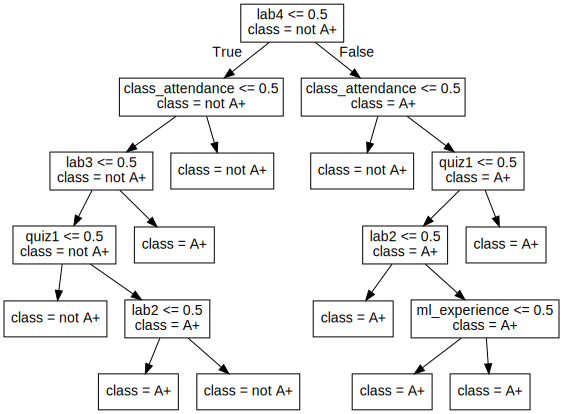

In [30]:

display_tree(X_binary.columns, model)

What's the prediction for the new example?

In [31]:
model.predict(new_example)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['A+'], dtype=object)

In summary, given a learned tree and a test example, during prediction time,  
- Start at the top of the tree. Ask binary questions at each node and follow the appropriate path in the tree. Once you are at a leaf node, you have the prediction. 
- Note that the model only considers the features which are in the learned tree and ignores all other features. 

### How does `fit` work? 

- Decision tree is inspired by [20-questions game](https://en.wikipedia.org/wiki/Twenty_questions). 
- Each node either represents a question or an answer. The terminal nodes (called leaf nodes) represent answers. 

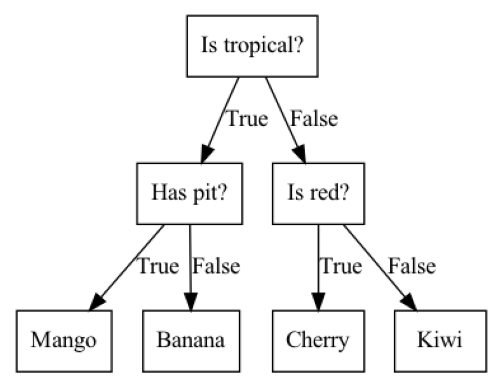

In [32]:
plot_fruit_tree()

### How does `fit` work? 

- Which features are most useful for classification? 
- Minimize **impurity** at each question
- Common criteria to minimize impurity: [gini index](https://scikit-learn.org/stable/modules/tree.html#classification-criteria), information gain, cross entropy

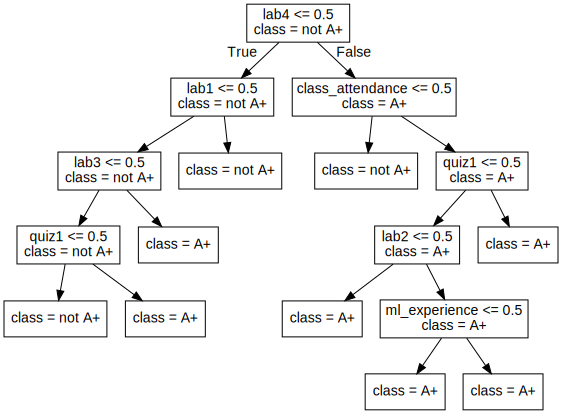

In [33]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier() # Create a decision tree
model.fit(X_binary, y) # Fit a decision tree
display_tree(X_binary.columns, model)

```{admonition} Warning 
:class: warning 
We won't go through **how** it does this - that's CPSC 340. But it's worth noting that it support two types of inputs: 
    1. Categorical (e.g., Yes/No or more options, as shown in the tree above)
    2. Numeric (a number)In the numeric case, the decision tree algorithm also picks the _threshold_. 
```

### Decision trees with continuous features

In [34]:
X.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1
0,1,1,92,93,84,91,92
1,1,0,94,90,80,83,91
2,0,0,78,85,83,80,80
3,0,1,91,94,92,91,89
4,0,1,77,83,90,92,85


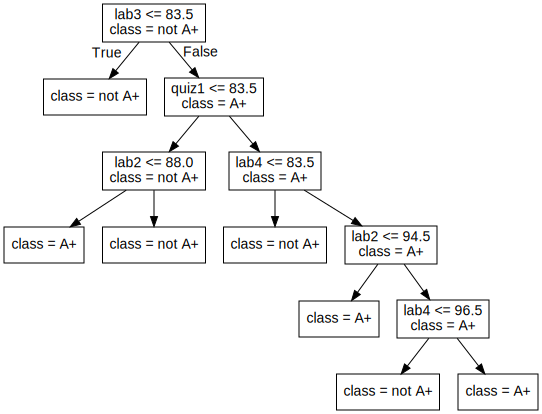

In [35]:
model = DecisionTreeClassifier()
model.fit(X, y)
display_tree(X.columns, model)

### Decision tree for regression problems

- We can also use decision tree algorithm for regression. 
- Instead of gini, we use [some other criteria](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation) for splitting. A common one is mean squared error (MSE). (More on this in later videos.)
- `scikit-learn` supports regression using decision trees with `DecisionTreeRegressor` 
    - `fit` and `predict` paradigms similar to classification
    - `score` returns somethings called [$R^2$ score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score).     
        - The maximum $R^2$ is 1 for perfect predictions. 
        - It can be negative which is very bad (worse than `DummyRegressor`). 


In [36]:
regression_df = pd.read_csv("data/quiz2-grade-toy-regression.csv")
regression_df.head()

,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2
0,1,1,92,93,84,91,92,90
1,1,0,94,90,80,83,91,84
2,0,0,78,85,83,80,80,82
3,0,1,91,94,92,91,89,92
4,0,1,77,83,90,92,85,90


In [37]:
X = regression_df.drop(["quiz2"], axis=1)
y = regression_df["quiz2"]

depth = 2
reg_model = DecisionTreeRegressor(max_depth=depth)
reg_model.fit(X, y); 
regression_df["predicted_quiz2"] = reg_model.predict(X)
print("R^2 score on the training data: %0.3f\n\n" % (reg_model.score(X, y)))
regression_df.head()

R^2 score on the training data: 0.989




,ml_experience,class_attendance,lab1,lab2,lab3,lab4,quiz1,quiz2,predicted_quiz2
0,1,1,92,93,84,91,92,90,90.333333
1,1,0,94,90,80,83,91,84,83.000000
2,0,0,78,85,83,80,80,82,83.000000
3,0,1,91,94,92,91,89,92,92.000000
4,0,1,77,83,90,92,85,90,90.333333


<br><br>

## ❓❓ Questions for you

### iClicker Exercise 2.5 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

- (A) Change in features (i.e., binarizing features above) would change `DummyClassifier` predictions. 
- (B) `predict` takes only `X` as argument whereas `fit` and `score` take both `X` and `y` as arguments. 
- (C) For the decision tree algorithm to work, the feature values must be binary.
- (D) The prediction in a decision tree works by routing the example from the root to the leaf.  
- (E) The decision tree algorithm creates an optimal tree. 

<br><br><br><br>

## More terminology [[video](https://youtu.be/KEtsfXn4w2E)]

- Parameters and hyperparameters
- Decision boundary 


```{seealso}
Check out [the accompanying video](https://youtu.be/KEtsfXn4w2E) on this material. 
```

### Parameters 

- The decision tree algorithm primarily learns two things: 
    - the best feature to split on
    - the threshold for the feature to split on at each node
- These are called **parameters** of the decision tree model.  
- When predicting on new examples, we need parameters of the model. 

In [38]:
classification_df = pd.read_csv("data/quiz2-grade-toy-classification.csv")
X = classification_df.drop(columns=["quiz2"])
y = classification_df["quiz2"]
model = DecisionTreeClassifier()
model.fit(X, y);

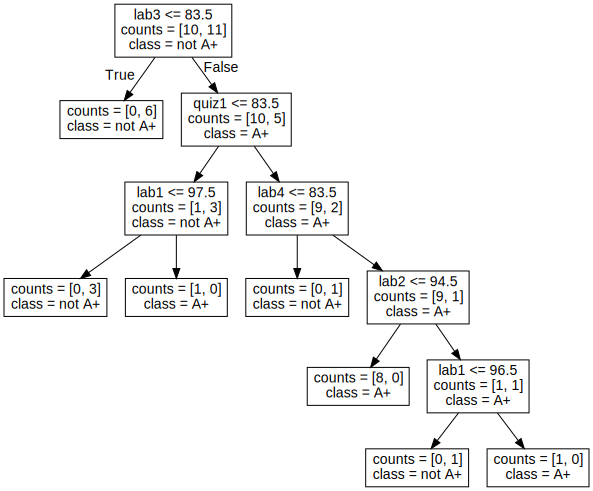

In [39]:
display_tree(X.columns, model, counts=True)

- With the default setting, the nodes are expanded until all leaves are "pure". 

- The decision tree is creating very specific rules, based on just one example from the data. 
- Is it possible to control the learning in any way? 
    - Yes! One way to do it is by controlling the **depth** of the tree, which is the length of the longest path from the tree root to a leaf.    

### Decision tree with `max_depth=1`

**Decision stump**
: A decision tree with only one split (depth=1) is called a **decision stump**. 

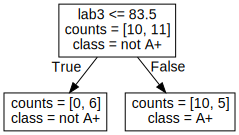

In [40]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
display_tree(X.columns, model, counts=True)

`max_depth` is a **hyperparameter** of `DecisionTreeClassifier`. 

### Decision tree with `max_depth=3`

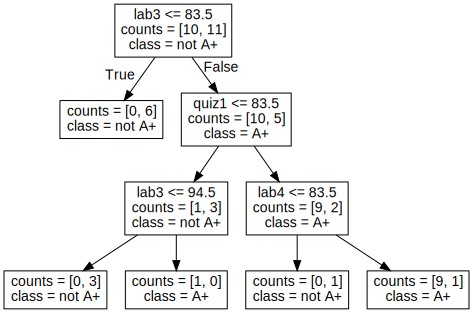

In [41]:
model = DecisionTreeClassifier(
    max_depth=3
)  # Let's try another value for the hyperparameter
model.fit(X, y)
display_tree(X.columns, model, counts=True)

### Parameters and hyperparameters: Summary 
**Parameters**
: When you call `fit`, a bunch of values get set, like the features to split on and split thresholds. These are called **parameters**. These are learned by the algorithm from the data during training. We need them during prediction time. 

**Hyperparameters**
: Even before calling `fit` on a specific data set, we can set some "knobs" that control the learning. These are called **hyperparameters**. These are specified based on: expert knowledge, heuristics, or systematic/automated optimization (more on this in the coming lectures).    

```{admonition} Attention
:class: important
In `sklearn` hyperparameters are set in the constructor. 
```

Above we looked at the `max_depth` hyperparameter. Some other commonly used hyperparameters of decision tree are:

- `min_samples_split`
- `min_samples_leaf`
- `max_leaf_nodes`

```{seealso}
See [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for other hyperparameters of a tree.
```

### Decision boundary 

What do we do with learned models? So far we have been using them to predict the class of a new instance. Another way to think about them is to ask: what sort of test examples will the model classify as positive, and what sort will it classify as negative? 

#### Example 1: quiz 2 grade prediction 

For visualization purposes, let's consider a subset of the data with only two features. 

In [42]:
X_subset = X[["lab4", "quiz1"]]
X_subset.head()

,lab4,quiz1
0,91,92
1,83,91
2,80,80
3,91,89
4,92,85


##### Decision boundary for `max_depth=1` 

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


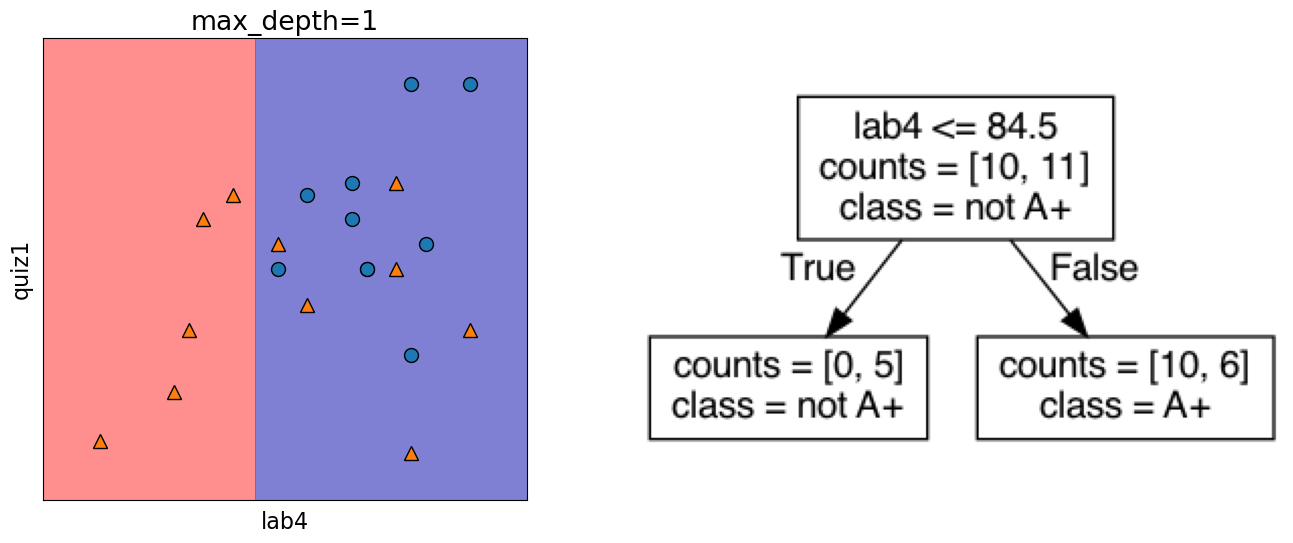

In [43]:
depth = 1  # decision stump
model = DecisionTreeClassifier(max_depth=depth)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

We assume geometric view of the data. Here, the red region corresponds to "not A+" class and blue region corresponds to "A+" class. And there is a line separating the red region and the blue region which is called the **decision boundary** of the model. Different models have different kinds of decision boundaries. 
In decision tree models, when we are working with only two features, the decision boundary is made up of horizontal and vertical lines. In the example above, the decision boundary is created by asking one question `lab4 <= 84.5`. 

##### Decision boundary for `max_depth=2` 

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


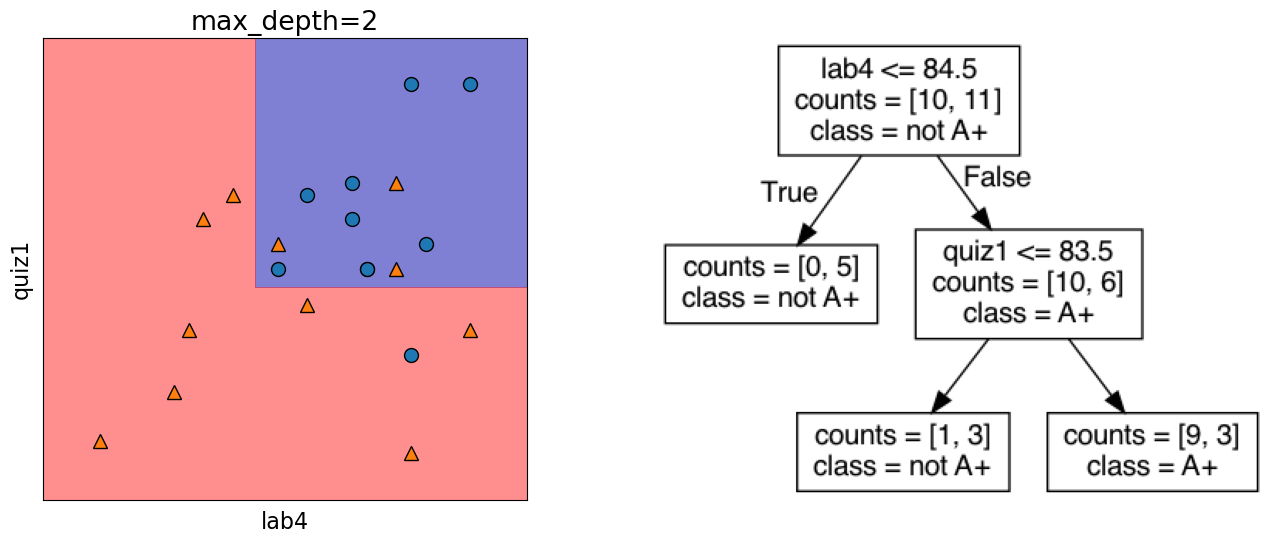

In [44]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

The decision boundary, i.e., the model gets a bit more complicated. 

##### Decision boundary for `max_depth=5` 

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


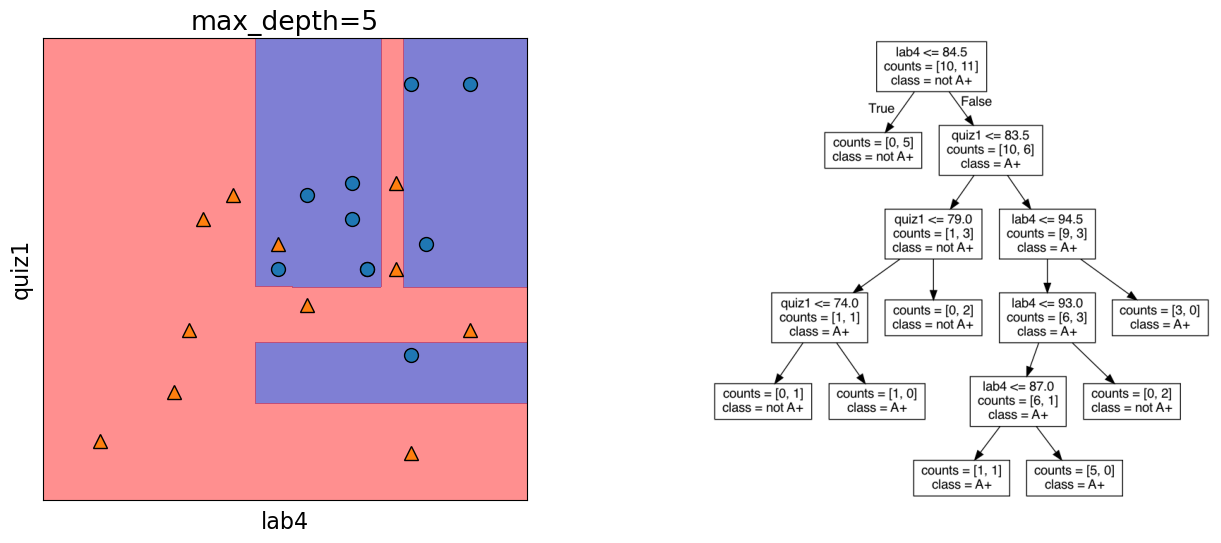

In [45]:
model = DecisionTreeClassifier(max_depth=5)
model.fit(X_subset, y)
plot_tree_decision_boundary_and_tree(
    model, X_subset, y, x_label="lab4", y_label="quiz1"
)

The decision boundary, i.e., the model gets even more complicated with `max_depth=5`. 

<br><br>

#### Example 2: Predicting country using the longitude and latitude 

Imagine that you are given longitude and latitude of some border cities of USA and Canada along with which country they belong to. Using this training data, you are supposed to come up with a classification model to predict whether a given longitude and latitude combination is in the USA or Canada. 

In [46]:
### US Canada cities data
df = pd.read_csv("data/canada_usa_cities.csv")
df

,longitude,latitude,country
0,-130.0437,55.9773,USA
1,-134.4197,58.3019,USA
2,-123.0780,48.9854,USA
3,-122.7436,48.9881,USA
4,-122.2691,48.9951,USA
...,...,...,...
204,-72.7218,45.3990,Canada
205,-66.6458,45.9664,Canada
206,-79.2506,42.9931,Canada
207,-72.9406,45.6275,Canada


In [47]:
X = df[["longitude", "latitude"]]

In [48]:
y = df["country"]

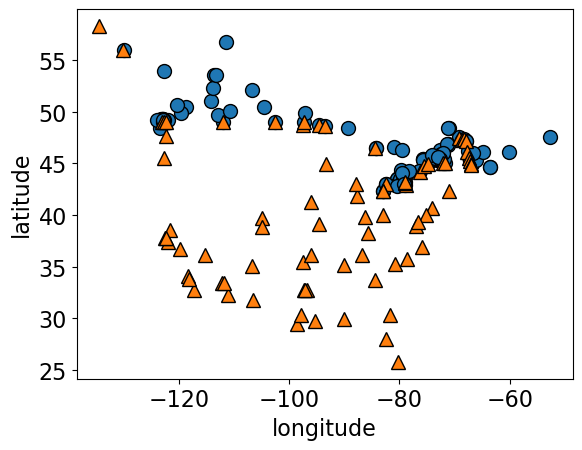

In [49]:
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y)
plt.xlabel("longitude")
plt.ylabel("latitude");

##### Real boundary between Canada and USA

In real life we know what's the boundary between USA and Canada. 

![](img/canada-us-border.jpg)

<!-- <img src="img/canada-us-border.jpg" height="500" width="500">  -->

[Source](https://sovereignlimits.com/blog/u-s-canada-border-history-disputes)

Here we want to pretend that we do not know this boundary and we want to infer this boundary based on the limited training examples given to us. 

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


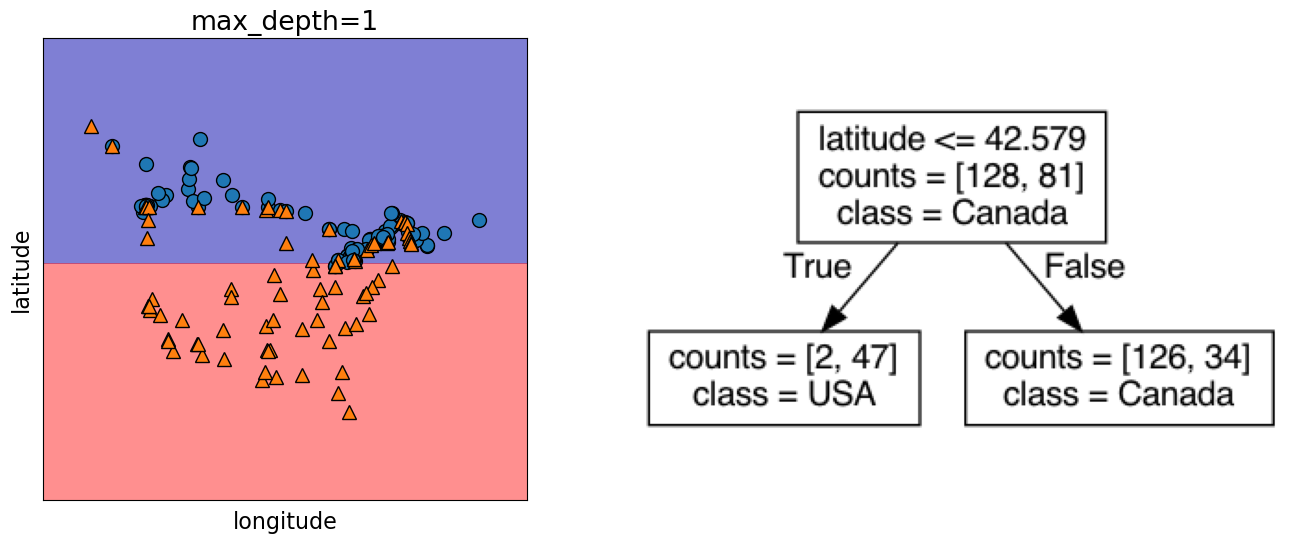

In [50]:
model = DecisionTreeClassifier(max_depth=1)
model.fit(X, y)
plot_tree_decision_boundary_and_tree(
    model,
    X,
    y,
    height=6,
    width=16,
    eps=10,
    x_label="longitude",
    y_label="latitude",
)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


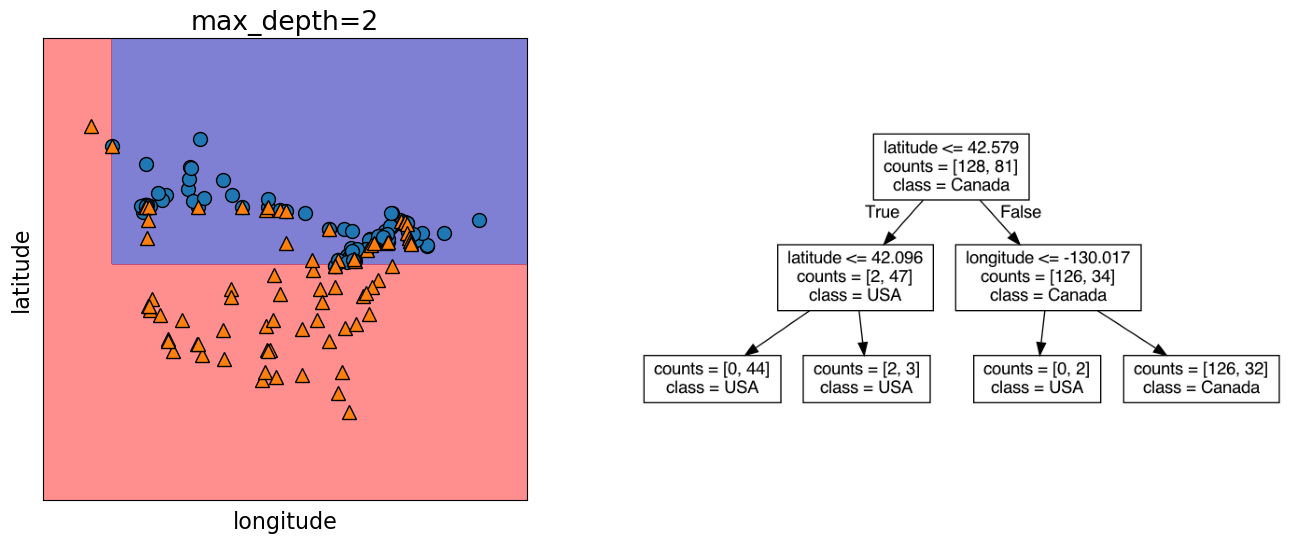

In [51]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X, y)
plot_tree_decision_boundary_and_tree(
    model,
    X,
    y,
    height=6,
    width=16,
    eps=10,
    x_label="longitude",
    y_label="latitude",
)

### Practice exercises 

- If you want more practice, check out module 2 in [this online course](https://ml-learn.mds.ubc.ca/en/module2). All the sections **without** video or notes symbol are exercises.  

```{admonition} Attention
:class: important
If all of you are working on the exercises, especially coding exercises, at the same time, you might have to wait for the real-time feedback for a long time or you might even get an error. There is no solution for this other than waiting for a while and trying it again. 
```

```{note}
Some background on [the online course](https://ml-learn.mds.ubc.ca/en/) above: This course is designed by Hayley Boyce, Mike Gelbart, and myself. It'll be a great resource at the beginning of this class, as it give you a chance to practice what we learn and the framework will provide you real-time feedback. 
```

<br><br><br><br>

## Final comments, summary, and reflection

What did we learn today? 

- There is a lot of terminology and jargon used in ML. Some of the basic 
terminology includes:
    - Features, target, examples, training
    - Supervised vs. Unsupervised machine learning     
    - Classification and regression    
    - Accuracy and error    
    - Parameters and hyperparameters
    - Decision boundary 

- Baselines and steps to train a supervised machine learning model 
    - Baselines serve as reference points in ML workflow. 

- Decision trees    
    - are models that make predictions by sequentially looking at features and checking whether they are above/below a threshold
    - learn a hierarchy of if/else questions, similar to questions you might ask in a 20-questions game.       
    - learn axis-aligned decision boundaries (vertical and horizontal lines with 2 features)    
    - One way to control the complexity of decision tree models is by using the depth hyperparameter (`max_depth` in `sklearn`). 

<br><br>

### Reflection

Write your reflections (takeaways, struggle points, and general comments) on this material in [the reflection Google Document](https://docs.google.com/document/d/1b4HJqJfhfI2Cfb5aBEzH28FooQmZ7sMZDbbidVCFl9M/edit?usp=sharing) so that I'll try to address those points in the next lecture. 

![](img/eva-logging-off.png)
